In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
# import rasterio

# mapping utilities
# import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [2]:
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'GitHub':
    git_dir = os.path.dirname(git_dir)
usr_dir = os.getcwd()
while os.path.basename(usr_dir) != 'Users':
    temp = os.path.basename(usr_dir)
    usr_dir = os.path.dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel'
plt_dir = gwfm_dir+'/Levee_setback/figures/'
gwfm_dir


'C:\\Users/ajcalder/Box/research_cosumnes/GWFlowModel'

## Pick model type to review
RIV is the simple model with only SS assumptions about Blodgett Dam depth and area
LAK is the complex model with interactive flow between the stream and Blodgett Dam

In [3]:
# model_type = 'RIV'
# model_type = 'LAK'

In [5]:
# run_dir = 'C://WRDAPP/GWFlowModel'
run_dir = 'F://WRDAPP/GWFlowModel'
loadpth = run_dir +'/Cosumnes/levee_setback/streamflow/'

runs = os.listdir(loadpth)
runs

['historical_SS',
 'historical_SS_realization033',
 'historical_SS_realization089',
 'historical_streamflow',
 'setback_streamflow']

In [50]:
# model_ws =loadpth+'/actual_200cfs'

# i=0
# os.listdir(loadpth+runs[i])
# glob.glob(loadpth+runs[i]+'/*.nam')[0]
# model_ws = loadpth+runs[i]

# model_ws = loadpth+'historical_streamflow'
model_ws = loadpth+'setback_streamflow'

model_type = 'LAK'

In [8]:

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='MODFLOW-NWT.exe', version='mfnwt')
# m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
#                                 exe_name='mf2005.exe', version='mf2005')

In [9]:
sfr_dir = gwfm_dir+'/SFR_data/'
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
m_domain = gpd.read_file(gwfm_dir+'\\NewModelDomain\\GWModelDomain_52_9deg_UTM10N_WGS84.shp')


C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

DriverError: C:\Users/ajcalder/Box/research_cosumnes/GWFlowModel\NewModelDomain\GWModelDomain_52_9deg_UTM10N_WGS84.shp: No such file or directory

In [10]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()
# cbc = model_ws+'/MF.cbc'


# Water budget processing

In [47]:
def zone_clean_tr(cbc,zon,  kstpkper):
    zb = flopy.utils.ZoneBudget(cbc, zon_dam)
    zb_df = zb.get_dataframes()
    # # ungroup by timestep
    zb_df = zb_df.reset_index()
    names = zb_df.name.unique()
    zb_df = zb_df.pivot(index = 'totim', columns = 'name',values = 'ZONE_1')

    # # multiply by -1 to have pulled out of water balance on plot
    zb_df.loc[:,zb_df.columns.str.contains('TO_')] *= -1

    # create date index
    zb_df['Date'] = pd.to_datetime(m.start_datetime)+zb_df.index.values.astype('timedelta64[D]')- np.ones(1).astype('timedelta64[D]')
    zb_df = zb_df.set_index('Date')
    return(zb_df)

In [12]:
# shapefile rectangle of the area surrounding the Dam within about 5 cells
zon_dam_gpd = gpd.read_file(gwfm_dir+'/Blodgett_Dam/geospatial/zon_bud_extent/zon_bud_extent.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')

zon_cells = gpd.sjoin(grid_p,zon_dam_gpd,how='right',op='within')
# zon_cells = gpd.sjoin(grid_p,zon_dam_gpd) #includes more cells, including with high conductance

# filter zone budget for Blodgett Dam to just within 5 cells or so of the Dam
# zon_dam = np.zeros((m.dis.nrow,m.dis.ncol),dtype=int)
zon_dam = np.zeros((grid_p.row.max(),grid_p.column.max()),dtype=int)

zon_dam[zon_cells.row-1,zon_cells.column-1]=1

zon_mod = np.ones((grid_p.row.max(),grid_p.column.max()),dtype=int)

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  aout[:] = out
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\geopandas\_vectorized.py:142: DeprecationWarning: An exception was ignored while fetching the attribute `__ar

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [59]:
dam_cols = ['FROM_RECHARGE','FROM_STREAM_LEAKAGE', 'TO_WELLS',
            'TO_STREAM_LEAKAGE','FROM_ZONE_0','TO_ZONE_0']
all_cols = ['FROM_CONSTANT_HEAD', 'FROM_RECHARGE','FROM_HEAD_DEP_BOUNDS','FROM_STREAM_LEAKAGE',
              'TO_CONSTANT_HEAD','TO_HEAD_DEP_BOUNDS', 'TO_WELLS','TO_STREAM_LEAKAGE']
if model_type =='LAK':
    extra_cols = ['FROM_LAKE_SEEPAGE','TO_LAKE_SEEPAGE']
    dam_cols = np.append(dam_cols,extra_cols)
    all_cols = np.append(all_cols,extra_cols)
# elif model_type == 'RIV':
#     extra_cols = ['FROM_RIVER_LEAKAGE','TO_RIVER_LEAKAGE']



zb_dam_all = pd.DataFrame(columns = dam_cols)
zb_dam_all.index.name = 'name'
zb_mod_all = pd.DataFrame(columns = all_cols)
zb_mod_all.index.name = 'name'

In [23]:
# load cbb file from any model scneario to get listing of kstpkper
cbc = model_ws+'/MF.cbc'
# zb = flopy.utils.ZoneBudget(cbc, zon_dam)
# kstpkper = zb.kstpkper



In [24]:
zb_df.index.values

array([1.])

In [74]:
zb_df = zone_clean_tr(cbc,zon_dam,spd_stp)

In [75]:
zb_dam_all = zb_df.loc[:,dam_cols]
zb_mod_all = zb_df.loc[:,all_cols]

In [87]:
# for i in np.arange(0,len(runs)):
#     cbc = loadpth+runs[i]+'/MF.cbc'

#     # cbc = m.model_ws+'/MF.cbc'
#     # # using 0 indicates not in zone
#     # zon = m.bas6.ibound[0,:,:]

#     # # Create a ZoneBudget object and get the budget record array

#     zb_df = zone_clean_tr(cbc,zon_dam, kstpkper)
#     final_cols = zb_df.columns.join(dam_cols,how='inner')
#     zb_dam_all = zb_dam_all.append(zb_df.loc[:,final_cols])

#     zb_df = zone_clean_tr(cbc,zon_mod, kstpkper)
#     final_cols = zb_df.columns.join(all_cols,how='inner')
#     zb_mod_all = zb_mod_all.append(zb_df.loc[:,final_cols])

In [27]:
# zb_dam_actual = zb_dam_all.iloc[0:2].reset_index(drop=True).loc[:,just_riv].sum(axis=1)
# zb_dam_design = zb_dam_all.iloc[2:4].reset_index(drop=True).loc[:,just_riv].sum(axis=1)
# zb_dam_new = zb_dam_all.iloc[4:].reset_index(drop=True).loc[:,just_riv].sum(axis=1)

# new_percent = (zb_dam_new-zb_dam_design)/zb_dam_design
# actual_percent = (zb_dam_actual-zb_dam_design)/zb_dam_design

# print('New cross-section percent increase in recharge: \n at 25cfs: %.2f' %(100*new_percent.loc[0]),
#       '  at 100 cfs: %.2f' %(100*new_percent.loc[1]))

# print('Actual conditions percent increase in recharge: \n at 25cfs:%.2f' %(100*actual_percent.loc[0]),
#       '  at 100 cfs: %.2f' %(100*actual_percent.loc[1]))

In [28]:
# zb_dam_actual, zb_dam_design, zb_dam_new
# new_percent

In [76]:
zon_color_dict = pd.read_csv(py_dir+'mf_wb_color_dict.csv',header=0, index_col='flux',skiprows=1).color.to_dict()
zon_name_dict = pd.read_csv(py_dir+'mf_wb_color_dict.csv',header=0, index_col='flux',skiprows=1).name.to_dict()
m3_2_AF = (1/0.3048**3)*(1/43560)

## Local water budget

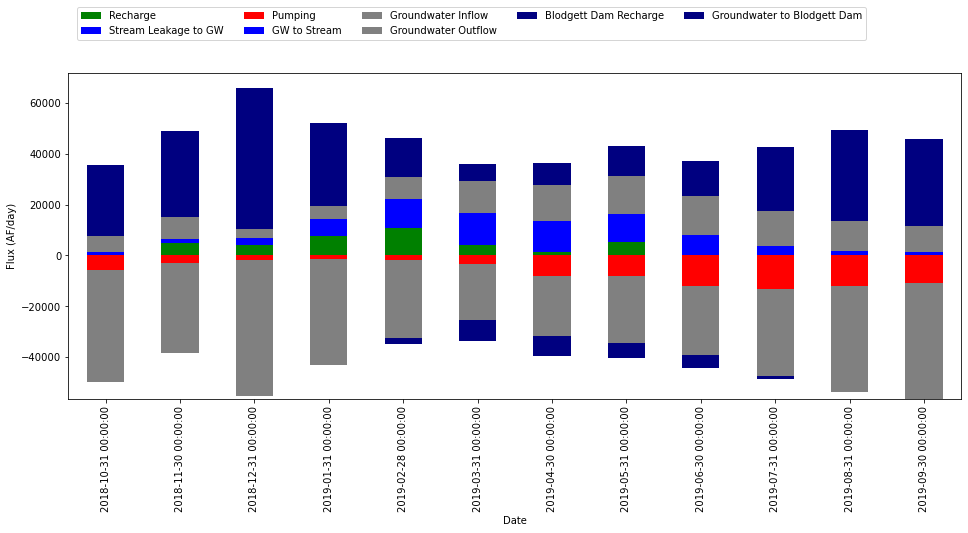

In [77]:
zb_dam_all_M = zb_dam_all.resample('M').mean()
fig, ax = plt.subplots(figsize=(16,6))

zb_dam_all_M.plot(y=dam_cols,
           kind='bar',ax=ax, stacked = True,legend=False,
               color=[zon_color_dict[x] for x in dam_cols], label = [zon_name_dict[x] for x in dam_cols])
plt.ylabel('Flux (AF/day)')
plt.legend(loc=(0.01,1.1),ncol=5)

In [96]:
# convert m3/day to AF/30 days
# zb_dam_all_AF = zb_dam_all*m3_2_AF

# fig, ax = plt.subplots(figsize=(16,6))
# zb_dam_all_AF.plot(y=dam_cols,
#            kind='bar',ax=ax, stacked = True,legend=False,
#                color=[zon_color_dict[x] for x in dam_cols], label = [zon_name_dict[x] for x in dam_cols])
# ax.xaxis.set_major_locator(mdates.MonthLocator())

# plt.ylabel('Flux (AF/day)')
# plt.legend(loc=(0.01,1.1),ncol=5)


# plt.xlabel('Scenario')
# plt.savefig(plt_dir+'/dam_all_AF_day.png',dpi=600,bbox_inches='tight')


## Domain water budget

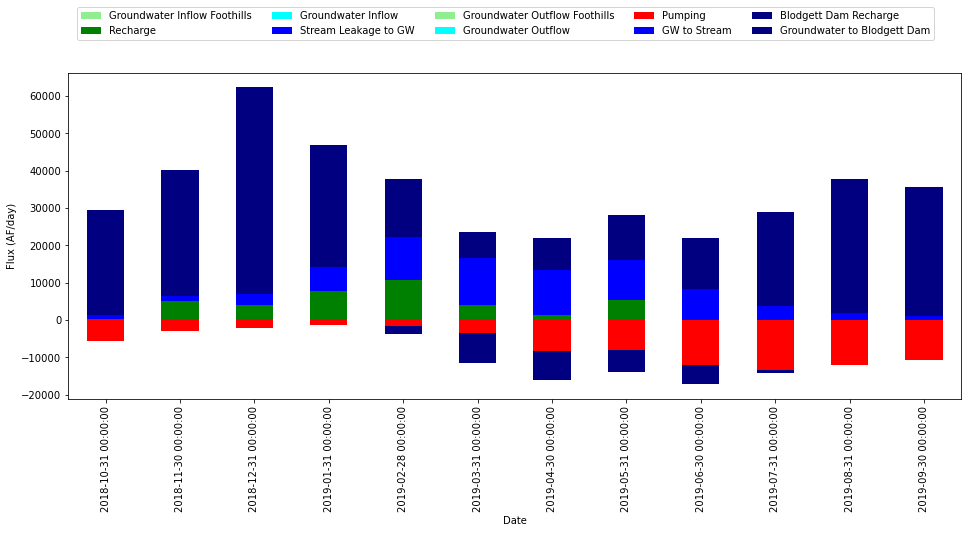

In [78]:
zb_mod_all_M = zb_mod_all.resample('M').mean()
fig, ax = plt.subplots(figsize=(16,6))

zb_mod_all_M.plot(y=all_cols,
           kind='bar',ax=ax, stacked = True,legend=False,
               color=[zon_color_dict[x] for x in all_cols], label = [zon_name_dict[x] for x in all_cols])
plt.ylabel('Flux (AF/day)')
plt.legend(loc=(0.01,1.1),ncol=5)

In [102]:
# convert m3/day to AF/day
# zb_mod_all_AF = zb_mod_all*m3_2_AF

# fig, ax = plt.subplots(figsize=(16,6))
# zb_mod_all_AF.plot(y=all_cols,
#            kind='bar',ax=ax, stacked = True,
#                color=[zon_color_dict[x] for x in all_cols], label = [zon_name_dict[x] for x in all_cols])

# # clean up x axis so there are not as many dates
# ax.xaxis.set_major_locator(mdates.MonthLocator())

# plt.legend(loc=(0.0,1.1),ncol=5)
# plt.ylabel('Flux (AF/day)')
# plt.title('Water Budget for Entire Domain')


# plt.savefig(plt_dir+'/domain_waterbudget_'+model_type+'_AF_day.png',dpi=600,bbox_inches='tight')

In [79]:
sfr_cols = ['name','row','column','segment', 'reach', 'Qin', 'Qaquifer', 'Qout',
            'stage', 'depth', 'width', 'Cond', 'gradient', 'kstpkper']

In [123]:
sfrdf_all = pd.DataFrame(columns = sfr_cols)
sfrdf_all.index.name = 'name'

sfrnam = model_ws+'/MF.sfr.out'
sfrout = flopy.utils.SfrFile(sfrnam)
sfrdf = sfrout.get_dataframe()
# for i in np.arange(0,len(runs)):
#     sfrnam = loadpth+runs[i]+'/MF.sfr.out'
#     sfrout = flopy.utils.SfrFile(sfrnam)
#     sfrdf = sfrout.get_dataframe()
#     sfrdf['name'] = runs[i]
#     sfrdf_all = sfrdf_all.append(sfrdf.loc[:,sfr_cols])

In [124]:

# sfrdf['seg_reach'] = list(zip(sfrdf.loc[:,['segment','reach']].values))

In [125]:
pd_sfr = pd.DataFrame(grid_sfr.set_index(['row','column']).loc[:,['length_m','z']])
pd_sfr['Total distance (m)'] = pd_sfr['length_m'].cumsum()

In [126]:
sfrdf_plot = pd_sfr.join(sfrdf.set_index(['row','column']),on=['row','column'],how='inner',lsuffix='_all')
sfrdf_plot['Qin_cfs'] = sfrdf_plot.Qin /(0.3048**3)/86400
sfrdf_plot['Qaquifer_AF'] = sfrdf_plot.Qaquifer /(0.3048**3)/43560

22430


<AxesSubplot:xlabel='Total distance (m)'>

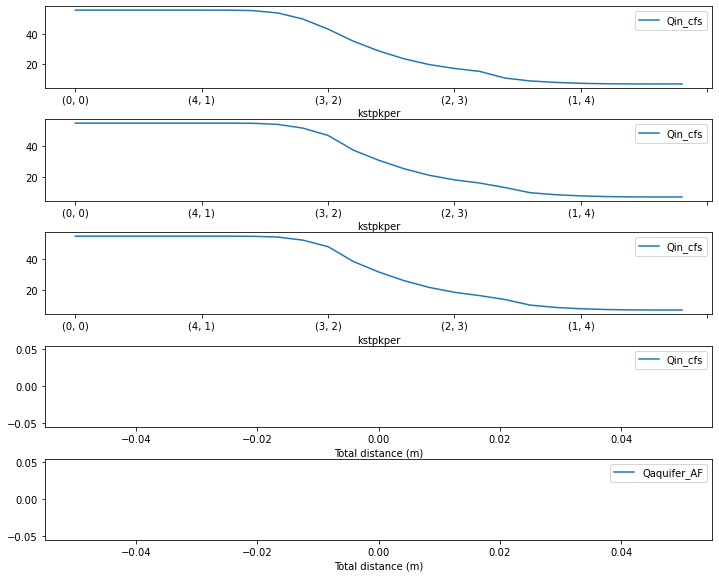

In [127]:
fig,ax=plt.subplots(5,1,figsize=(10,8))
fig.tight_layout()
sfrdf_plot.loc[(sfrdf_plot.segment ==16)&(sfrdf_plot.reach==1)].plot(x='kstpkper',y='Qin_cfs',ax=ax[0])
sfrdf_plot.loc[(sfrdf_plot.segment ==17)&(sfrdf_plot.reach==1)].plot(x='kstpkper',y='Qin_cfs',ax=ax[1])
sfrdf_plot.loc[(sfrdf_plot.segment ==18)&(sfrdf_plot.reach==1)].plot(x='kstpkper',y='Qin_cfs',ax=ax[2])

print(sfrdf_plot.loc[(sfrdf_plot.segment ==16)&(sfrdf_plot.reach==1)]['Total distance (m)'].min())
# sfrdf_plot.loc[(sfrdf_plot.segment ==16)&(sfrdf_plot.reach==1)].plot(x='kstpkper',y='Qaquifer_AF')
sfrdf_plot.loc[sfrdf_plot.kstpkper==(3,167)].plot(x='Total distance (m)',y='Qin_cfs',ax=ax[-2])
sfrdf_plot.loc[sfrdf_plot.kstpkper==(3,167)].plot(x='Total distance (m)',y='Qaquifer_AF',ax=ax[-1])


In [159]:
# temp = sfrdf_plot.loc[sfrdf_plot.name=='actual_0025cfs']
# temp = temp.loc[(temp.segment>13)&(temp.segment<21)]
# # temp.plot(x='Total distance (m)',y='Qin')
# temp.plot(x='segment',y='Qin')

Text(0, 0.5, 'Streambed seepage (AF/day)')

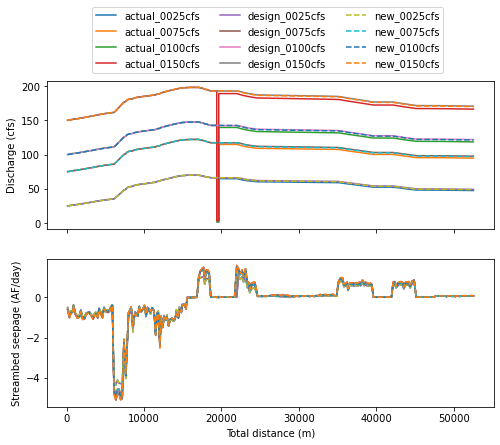

In [160]:
# fig,ax=plt.subplots(2,1,figsize=(8,6),sharex=True)
# for i in sfrdf_plot.name.unique():
#     typ='-'
#     if 'new' in i:
#         typ='--'
# #     elif 'actual' in i:
# #         typ = '-*'
#     sfrdf_plot.loc[sfrdf_plot.name==i].plot(ax=ax[0],x='Total distance (m)',y='Qin_cfs',label=i,legend=False, style=typ)
#     sfrdf_plot.loc[sfrdf_plot.name==i].plot(ax=ax[1],x='Total distance (m)',y='Qaquifer_AF',label=i,legend=False, style=typ)

# # plt.legend(orientation='horizontal')
# ax[0].legend(loc=[0.1,1.05],ncol=3)
# ax[0].set_ylabel('Discharge (cfs)')
# ax[1].set_ylabel('Streambed seepage (AF/day)') #($m^3$/d)

# plt.savefig(plt_dir+'/streamflow between scenarios '+model_type+'.png',dpi=600,bbox_inches='tight')

C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\ajcalder\Anaconda3\envs\geosp\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


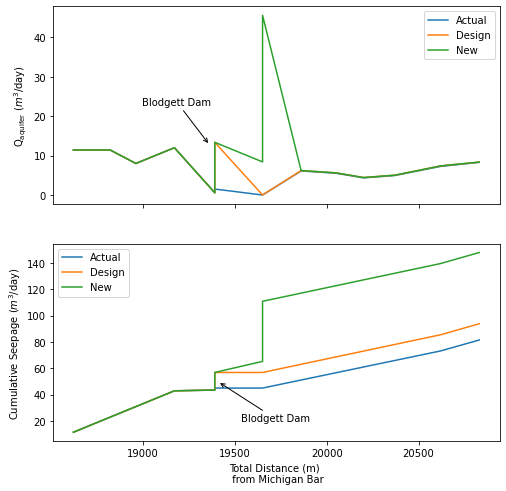

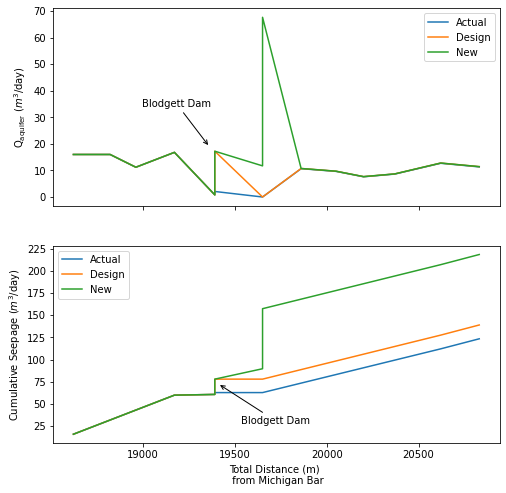

In [162]:

for flow in ['0025','0100']:
    fig,axes = plt.subplots(2,1,figsize=(8,8),sharex=True)

    ax=axes[0]
    flownam = '_'+flow+'cfs'
    if75 = (sfrdf_plot.name=='actual'+flownam) |(sfrdf_plot.name=='design'+flownam)|(sfrdf_plot.name=='new'+flownam)
    sfrdf_75 = sfrdf_plot.loc[if75]
    sfrdf_75_dam = sfrdf_75.loc[(sfrdf_75['Total distance (m)']>18600 ) &(sfrdf_75['Total distance (m)']<21000)]

    # sfrdf_75_dam.Qaquifer = sfrdf_75_dam.groupby('name').cumsum().Qaquifer
    sfrdf_75_dam.groupby('name').plot(x = 'Total distance (m)',y='Qaquifer',ax=ax)

    ax.legend(['Actual','Design','New'])
    ax.set_ylabel('$\mathregular{Q_{aquifer}}$ ($m^3$/day)')

    ax.annotate("Blodgett Dam", xy=(0.35, 0.3), xytext=(0.2,0.5), xycoords="axes fraction",
               arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))

    ax=axes[1]
    # filter out just 75 cfs scenario for comparison
    if75 = (sfrdf_plot.name=='actual'+flownam) |(sfrdf_plot.name=='design'+flownam)|(sfrdf_plot.name=='new'+flownam)
    sfrdf_75 = sfrdf_plot.loc[if75]
    sfrdf_75_dam = sfrdf_75.loc[(sfrdf_75['Total distance (m)']>18600 ) &(sfrdf_75['Total distance (m)']<21000)]

    # fig,ax = plt.subplots(figsize=(6,6))
    sfrdf_75_dam.Qaquifer = sfrdf_75_dam.groupby('name').cumsum().Qaquifer
    sfrdf_75_dam.groupby('name').plot(x = 'Total distance (m)',y='Qaquifer',ax=ax)

    ax.legend(['Actual','Design','New'])
    ax.set_ylabel('Cumulative Seepage ($m^3$/day)')
    ax.set_xlabel('Total Distance (m) \n from Michigan Bar')

    ax.annotate("Blodgett Dam", xy=(0.37, 0.3), xytext=(0.42,0.1), xycoords="axes fraction",
               arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc3"))
#     plt.savefig(plt_dir+'sfr stream seepage all'+flownam+'.png',dpi=600,bbox_inches='tight')

In [30]:
# gage file output
#Option 0: Use standard default listing of time, stage, volume, and concentration.
#Option 1: Default values plus all inflows to and outflows from lake (as volumes during time increment),
#total lake conductance, and time-step budget error (percent).
#Computed runoff from UZF and lake infiltration to UZF is added whenever the UZF Package is active 
gage_cols = ['time','stage','volume','conc','inflows','outflows','conductance','error']

In [65]:
runs[0:8]

['historical_SS',
 'historical_SS_realization033',
 'historical_SS_realization089',
 'historical_streamflow',
 'setback_streamflow']

In [132]:
def read_gage(run):
    gagenam = loadpth+run+'/MF.gage1.go'
    gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')
    cols = gage.columns[1:-1]
    gage = gage.dropna(axis=1)
    gage.columns = cols
    gage['name'] = run
    return(gage)

gage = read_gage(runs[4])

# for i in np.arange(1,len(runs[0:8])):
#     go = read_gage(runs[i])
#     gage = gage.append(go)


<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
<>:3: DeprecationWarning: invalid escape sequence \s
C:\Users\ajcalder\AppData\Local\Temp/ipykernel_525216/3326661535.py:3: DeprecationWarning: invalid escape sequence \s
  gage = pd.read_csv(gagenam,skiprows=1, delimiter = '\s+', engine='python')


In [133]:
# get last period, all is basically the same
# gage = gage.loc[gage.Time == gage.Time.max()]

gage['Inflw_cfs'] = gage['SW-Inflw']*6 /(0.3048**3)/86400

gage['Seepage_cfs']  = gage['GW-Outflw']*6 /(0.3048**3)/86400

gage

,Time,Stage(H),Volume,Precip.,Evap.,Runoff,GW-Inflw,GW-Outflw,SW-Inflw,SW-Outflw,Withdrawal,Lake-Inflx,Total-Cond.,Percent-Err,name,Inflw_cfs,Seepage_cfs
0,0.000000,0.11905,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.000000e+00,setback_streamflow,0.000000,0.000000
1,1.000000,0.11905,0.0,0.0,0.0,0.0,0.0,46529.7790,136241.0800,0.0,0.0,0.0,0.0,6.584747e+01,setback_streamflow,334.118634,114.109975
2,1.166667,0.11905,0.0,0.0,0.0,0.0,0.0,8665.6485,22706.8730,0.0,0.0,0.0,0.0,6.183689e+01,setback_streamflow,55.686504,21.251701
3,1.333333,0.11905,0.0,0.0,0.0,0.0,0.0,8799.4973,22706.8730,0.0,0.0,0.0,0.0,6.124743e+01,setback_streamflow,55.686504,21.579952
4,1.500000,0.11905,0.0,0.0,0.0,0.0,0.0,8842.1319,22706.8730,0.0,0.0,0.0,0.0,6.105967e+01,setback_streamflow,55.686504,21.684510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,48.833333,0.11905,0.0,0.0,0.0,0.0,0.0,5044.4461,5044.4461,0.0,0.0,0.0,0.0,0.000000e+00,setback_streamflow,12.371037,12.371037
289,49.000000,0.11905,0.0,0.0,0.0,0.0,0.0,5052.8732,5052.8732,0.0,0.0,0.0,0.0,0.000000e+00,setback_streamflow,12.391704,12.391704
290,49.166667,0.11905,0.0,0.0,0.0,0.0,0.0,5059.1467,5059.1467,0.0,0.0,0.0,0.0,0.000000e+00,setback_streamflow,12.407089,12.407089
291,49.333333,0.11905,0.0,0.0,0.0,0.0,0.0,5075.0093,5075.0093,0.0,0.0,0.0,0.0,1.792104e-14,setback_streamflow,12.445990,12.445990


In [34]:
def calc_lak_out(C, n, slope, lak_stage, str_top, width):
    # is either 1.486 for cfs or 1 for cms or 86400 for cmd
    flow = (C/n)*width*(((lak_stage-str_top)*(2/3))**(5/3))*((slope)**(1/2))
    return(flow)
dam_str_top = 22.111436
# dam_str_top = 21.92
dam_slope = 0.0003
# dam_slope = 0.0008
dam = calc_lak_out(86400,0.048,dam_slope,22.594511, dam_str_top,20)

s1 = (124.5-116.5)/(1000*6+500+750)
s2 = (114.85-110.65)/(1000*4+559*2)
s1,s2
ex1 = calc_lak_out(C=1.486*86400,n = 0.05,slope = s2,lak_stage=118.10,str_top = 114.85,width=5)
dam, ex1

(94348.56532363672, 1334321.7323914967)

In [35]:
sfrdf_plot.loc[(sfrdf_plot.segment==1)&(sfrdf_plot.reach==1)]

NameError: name 'sfrdf_plot' is not defined

In [169]:
sfrdf_plot.loc[sfrdf_plot.segment==16]

length_m          z  Total distance (m)            name segment  \
row  column                                                                    
53.0 151.0        260  23.111436               19650  actual_0025cfs      16   
     151.0        260  23.111436               19650  actual_0075cfs      16   
     151.0        260  23.111436               19650  actual_0100cfs      16   
     151.0        260  23.111436               19650  actual_0150cfs      16   
     151.0        260  23.111436               19650  design_0025cfs      16   
     151.0        260  23.111436               19650  design_0075cfs      16   
     151.0        260  23.111436               19650  design_0100cfs      16   
     151.0        260  23.111436               19650  design_0150cfs      16   
     151.0        260  23.111436               19650     new_0025cfs      16   
     151.0        260  23.111436               19650     new_0075cfs      16   
     151.0        260  23.111436               19650     new_0100cfs      16   
     151.0        260  23.111436               19650     new_0150cfs      16   

            reach       Qin  Qaquifer      Qout    stage    depth   width  \
row  column                                                                 
53.0 151.0      1    2886.7    0.0000    2886.7  22.1653  0.05387   12.36   
     151.0      1    5395.4    0.0000    5395.4  22.1897  0.07830   12.52   
     151.0      1    6631.4    0.0000    6631.4  22.2000  0.08857   12.59   
     151.0      1    9100.5    0.0000    9100.5  22.2184  0.10700   12.71   
     151.0      1  161290.0    0.0000  161290.0  22.6816  0.57010   85.23   
     151.0      1  286380.0    0.0000  286380.0  22.7744  0.66300  102.40   
     151.0      1  348130.0    0.0000  348130.0  22.8100  0.69860  107.20   
     151.0      1  471510.0    0.0000  471510.0  22.8725  0.76110  115.70   
     151.0      1  161720.0    8.4059  161720.0  22.9863  0.87480   76.22   
     151.0      1  286860.0   11.1470  286850.0  23.0943  0.98280   96.74   
     151.0      1  348610.0   11.7160  348600.0  23.1313  1.02000  100.20   
     151.0      1  472000.0   12.0660  471990.0  23.1915  1.08000  100.80   

              Cond  gradient kstpkper   seg_reach     Qin_cfs  Qaquifer_AF  
row  column                                                                 
53.0 151.0   0.000     1.035  (0, 20)  ([16, 1],)    1.179894     0.000000  
     151.0   0.000     1.051  (0, 20)  ([16, 1],)    2.205286     0.000000  
     151.0   0.000     1.058  (0, 20)  ([16, 1],)    2.710482     0.000000  
     151.0   0.000     1.070  (0, 20)  ([16, 1],)    3.719689     0.000000  
     151.0   0.000     1.374  (0, 20)  ([16, 1],)   65.924799     0.000000  
     151.0   0.000     1.435  (0, 20)  ([16, 1],)  117.053406     0.000000  
     151.0   0.000     1.458  (0, 20)  ([16, 1],)  142.292765     0.000000  
     151.0   0.000     1.499  (0, 20)  ([16, 1],)  192.722436     0.000000  
     151.0   3.502     1.573  (0, 20)  ([16, 1],)   66.100554     0.006815  
     151.0   4.444     1.644  (0, 20)  ([16, 1],)  117.249598     0.009037  
     151.0   4.603     1.669  (0, 20)  ([16, 1],)  142.488958     0.009498  
     151.0   4.631     1.708  (0, 20)  ([16, 1],)  192.922716     0.009782

## XS Plotting

In [4]:
# designed scenario flow through dam only
design_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/02_designed_XS.csv', skiprows=1)
# current situation, flow around dam and after dam
actual_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/03_actual_XS.csv', skiprows=1)
# remove XS for at dam
actual_xs = actual_xs.iloc[:,:6]
# depending scenario, use different input cross sections for 16.5
new_xs = pd.read_csv(gwfm_dir+'/Blodgett_Dam/geospatial/01_New_wide_XS.csv', skiprows=1)

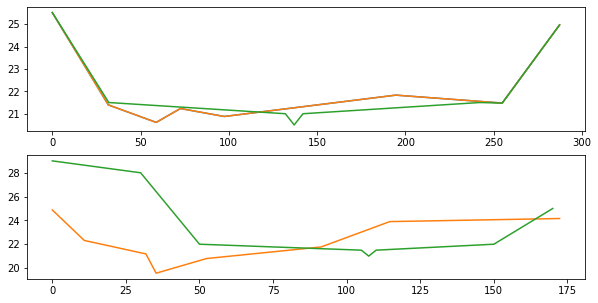

In [51]:
# 

# all_xs = design_xs.assign(id_col='Design').append(actual_xs.assign(id_col='Actual')).append(new_xs.assign(id_col='New'))
# all_xs = all_xs.set_index('id_col')
# fig,ax = plt.subplots(2,1, figsize=(10,5))

# for c, i in enumerate(np.arange(2,6,2)):
#     for n in all_xs.index.unique():
#         plt_xs = all_xs.loc[all_xs.index==n,:]
# #         print(plt_xs)
#         ax[c].plot(plt_xs.iloc[:,i],plt_xs.iloc[:,i+1])
# plt.legend(['Designed'])

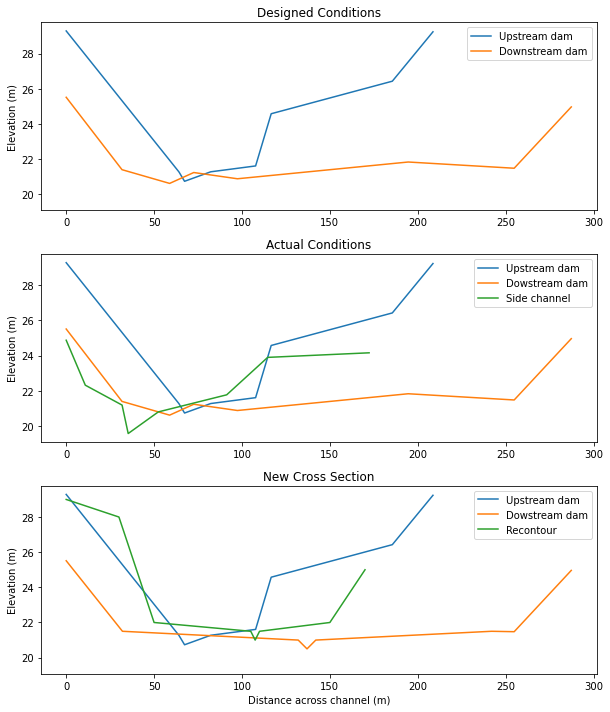

In [38]:
fig,ax=plt.subplots(3,1,figsize=(15,10),sharey=True)
for i in np.arange(0,3):
    ax[i].set_aspect(10)
    ax[i].set_ylabel("Elevation (m)")

for i in np.arange(0,len(new_xs.columns),2):
    ax[2].plot(new_xs.iloc[:,i],new_xs.iloc[:,i+1], label=new_xs.columns[i])
ax[2].legend(['Upstream dam','Dowstream dam','Recontour'])
ax[2].set_title('New Cross Section')

for i in np.arange(0,len(actual_xs.columns),2):
    ax[1].plot(actual_xs.iloc[:,i],actual_xs.iloc[:,i+1], label=actual_xs.columns[i])
ax[1].legend(['Upstream dam','Dowstream dam','Side channel'])
ax[1].set_title('Actual Conditions')

for i in np.arange(0,len(design_xs.columns),2):
    ax[0].plot(design_xs.iloc[:,i],design_xs.iloc[:,i+1], label=design_xs.columns[i])
ax[0].legend(['Upstream dam','Downstream dam'])
ax[0].set_title('Designed Conditions')


# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('Distance across channel (m)')


fig.tight_layout()
plt.savefig(plt_dir+'/different_scenario_XS.png',dpi=600,bbox_inches='tight')

## Annual sum water budget

In [ ]:
def annual_WB(zb_annual,unit, zon):
    # if unit = AF convert units, else leave as m3
    if unit == 'AF':
        # ((1 ft/ 0.3048 m)^3) * (1 acre/43560 ft2)
        zb_annual = zb_annual/((0.3048**3) *43560)
    if zon == 'valley':
        cols = [ 'FROM_RECHARGE', 'FROM_ZONE_0', 'TO_ZONE_0', 'TO_WELLS']        
    elif zon == 'all':
        cols = ['FROM_CONSTANT_HEAD', 'FROM_GHB', 'FROM_RECHARGE', 'TO_CONSTANT_HEAD', 'TO_GHB', 'TO_WELLS']

    #fixes issues with line and bar plotting
    zb_annual.index = zb_annual.index.astype(str)
    
    fig, ax = plt.subplots(figsize=(16,6))
    # clean up x axis so there are not as many dates
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    zb_annual.plot(y=['dSTORAGE'],ax=ax, color = 'black')
    # define columns to plot
    
    # plot acre ft instead of meters
    zb_annual.plot(y= cols,
               kind='bar',ax=ax, stacked = True)
    plt.ylabel('Flux (ac-ft/year)')

    zb_annual.plot(y=['SUM_dSTORAGE'],ax=ax, secondary_y = True,rot=90)
    plt.xticks(rotation=90)
    ax.yaxis.set_major_locator(MaxNLocator(5)) 

    plt.ylabel('Flux (ac-ft/year)')
    plt.xlabel('Datetime')
    plt.title('Water Budget for Butte Valley')
    plt.savefig(m.model_ws+'/Plots/annualsum_WB_'+zon+'_'+unit+'.png',dpi=300,bbox_inches = 'tight')
    zb_annual.to_csv(m.model_ws+'/Plots/annualsum_WB_'+zon+'_'+unit+'.csv')

In [ ]:
annual_WB(zb_annual118,unit = 'AF',zon='valley')
annual_WB(zb_annual,unit = 'AF',zon='all')

In [ ]:
def monthly_WB(zb_df,unit, zon, wy,name):
    plt_strt = pd.to_datetime(str(wy-1)+'-10-01')
    plt_end = pd.to_datetime(str(wy)+'-9-30')
    zb_plot = zb_df.loc[(zb_df.index>plt_strt)&(zb_df.index<plt_end)]
    zb_plot.index = zb_plot.index.astype(str)
    # if unit = AF convert units, else leave as m3
    if unit == 'AF':
        # ((1 ft/ 0.3048 m)^3) * (1 acre/43560 ft2)
        zb_plot = zb_plot/((0.3048**3) *43560)
    if zon == 'valley':
        cols = [ 'FROM_RECHARGE', 'FROM_ZONE_0', 'TO_ZONE_0', 'TO_WELLS']        
    elif zon == 'all':
        cols = ['FROM_CONSTANT_HEAD', 'FROM_GHB', 'FROM_RECHARGE', 'TO_CONSTANT_HEAD', 'TO_GHB', 'TO_WELLS']

    #fixes issues with line and bar plotting
    zb_plot.index = zb_plot.index.astype(str)
    
    fig, ax = plt.subplots(figsize=(16,6))
    # clean up x axis so there are not as many dates
    # ax.xaxis.set_major_locator(mdates.MonthLocator())
    zb_plot.plot(y=['dSTORAGE'],ax=ax, color = 'black')
    ax.hlines(y=0, xmin = -1, xmax = 100, color = 'black')

    # plot acre ft instead of meters
    zb_plot.plot(y= cols,
               kind='bar',ax=ax, stacked = True)
    plt.ylabel('Flux (ac-ft/month)')

    zb_plot.plot(y=['SUM_dSTORAGE'],ax=ax, secondary_y = True,rot=90)
    plt.xticks(rotation=90)
    ax.yaxis.set_major_locator(MaxNLocator(5)) 

    plt.ylabel('Flux (ac-ft/month)')
    plt.xlabel('Datetime')
    plt.title('Water Budget for Butte Valley WY'+str(wy)+' - '+name+' Year' )
    plt.savefig(m.model_ws+'/Plots/'+name+'_'+str(wy)+'monthlyWB_'+zon+'_'+unit+'.png',dpi=300,bbox_inches = 'tight')

In [ ]:
monthly_WB(zb_df_mon,unit='AF', zon='all', wy=1999,name='Wet')
monthly_WB(zb_df_mon,unit='AF', zon='all', wy=2005,name='Avg')
monthly_WB(zb_df_mon,unit='AF', zon='all', wy=2014,name='Dry')